In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import sqlalchemy as sa
import altair as alt
from altair.expr import datum

In [2]:
# we need to run this line to use Altair in a Jupyter notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
# Altair raises a MaxRowsError exception when passing a dataset with more than 5000 rows.
ALTAIR_LIMIT = 5000
# The limit of 5000 rows can be disabled with this line
# https://altair-viz.github.io/user_guide/faq.html#maxrowserror-how-can-i-plot-large-datasets
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [4]:
ROOT = os.path.abspath(os.path.pardir)
DB_NAME = 'TSA.db'
DB_PATH = os.path.abspath(os.path.join(ROOT, DB_NAME))
PLOTS_PATH = os.path.abspath(os.path.join(ROOT, 'plots'))
print(DB_PATH)
print(PLOTS_PATH)

/home/giacomo/repos/reddit-dataviz-battle-2018-08/TSA.db
/home/giacomo/repos/reddit-dataviz-battle-2018-08/plots


In [5]:
engine = sa.create_engine(f"sqlite:///{DB_PATH}")

# Find all years available in the database

SQLite does not have a storage class for storing dates and/or times, but it does have [functions](https://sqlite.org/lang_datefunc.html) to convert a `TEXT` datatype to a date/time representation convenient for us. See also [here](https://www.techonthenet.com/sqlite/functions/date.php).

In [6]:
sql = '''
SELECT DISTINCT date(c.date_received) AS date
FROM claims AS c
WHERE date IS NOT NULL
'''

We specify the date fields and their format string with Pandas, so we end up with a `Timestamp` object.

In [7]:
df = pd.read_sql(sql, con=engine, parse_dates={'date': '%Y-%m-%d'})
print(type(df.date.iloc[0]))
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


date
0 2002-01-04
1 2002-02-02
2 2002-02-04
3 2002-02-07
4 2002-02-18

Add a few columns to identify year, month and weekday. These will be useful when creating the Altair plots.

In [8]:
def add_time_columns(df_in, date_col):
    df_out = df_in
    df_out['year'] = pd.to_datetime(df_in[date_col]).apply(lambda ts: ts.strftime('%Y'))
    df_out['month_number'] = pd.to_datetime(df_in[date_col]).apply(lambda ts: ts.strftime('%m'))
    df_out['month_human'] = pd.to_datetime(df_in[date_col]).apply(lambda ts: ts.strftime('%b'))
    df_out['day_of_year'] = pd.to_datetime(df_in[date_col]).apply(lambda ts: ts.strftime('%j'))
    df_out['weekday_number'] = pd.to_datetime(df_in[date_col]).apply(lambda ts: ts.strftime('%w'))
    df_out['weekday_human'] = pd.to_datetime(df_in[date_col]).apply(lambda ts: ts.strftime('%a'))
    return df_out

In [9]:
df = add_time_columns(df, 'date')
df.head()

date  year month_number month_human day_of_year weekday_number  \
0 2002-01-04  2002           01         Jan         004              5   
1 2002-02-02  2002           02         Feb         033              6   
2 2002-02-04  2002           02         Feb         035              1   
3 2002-02-07  2002           02         Feb         038              4   
4 2002-02-18  2002           02         Feb         049              1   

  weekday_human  
0           Fri  
1           Sat  
2           Mon  
3           Thu  
4           Mon

We also define lists of strings for years, months and weekdays. We will need them in the Altair plots.

In [12]:
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years_int = sorted(df.year.unique().astype(int))
years = [f"{y}" for y in years_int[:16]]  # TODO: some years were incorrectly parsed (e.g 2208)
print(years)

['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']


## 3 airlines with the highest close amounts paid in these years

*Note:* I had to use `trim` because some airline names in my database have empty characters at the end.

In [15]:
sql = '''
SELECT DISTINCT
  trim(c.airline_name) AS airline,
  SUM(c.close_amount) as total_paid
FROM claims AS c
GROUP BY airline
HAVING
  airline NOT NULL AND
  total_paid > 0
ORDER BY total_paid DESC
LIMIT 3
'''

In [16]:
df = pd.read_sql(sql, con=engine)
df

airline  total_paid
0   American Airlines  2401763.81
1  Southwest Airlines  2315751.56
2     Delta Air Lines  2276482.00

## How much is paid in TSA claims for these 3 airlines, each day

In [17]:
sql = '''
SELECT
  date(c.date_received) AS date,
  c.airline_name AS airline,
  SUM(c.close_amount) as total_paid
FROM claims AS c
WHERE
  airline IN ("American Airlines", "Southwest Airlines", "Delta Air Lines")
GROUP BY date
HAVING date NOT NULL
ORDER BY total_paid DESC
'''

In [18]:
df = pd.read_sql(sql, con=engine)
df.shape

(2451, 3)

In [19]:
df.head()

date             airline  total_paid
0  2003-02-21     Delta Air Lines   500971.56
1  2003-06-10  Southwest Airlines    38782.40
2  2003-12-17   American Airlines    30167.29
3  2003-05-20  Southwest Airlines    29272.94
4  2004-05-04     Delta Air Lines    27640.05

In [20]:
df = add_time_columns(df, 'date')
df.head()

date             airline  total_paid  year month_number month_human  \
0  2003-02-21     Delta Air Lines   500971.56  2003           02         Feb   
1  2003-06-10  Southwest Airlines    38782.40  2003           06         Jun   
2  2003-12-17   American Airlines    30167.29  2003           12         Dec   
3  2003-05-20  Southwest Airlines    29272.94  2003           05         May   
4  2004-05-04     Delta Air Lines    27640.05  2004           05         May   

  day_of_year weekday_number weekday_human  
0         052              5           Fri  
1         161              2           Tue  
2         351              3           Wed  
3         140              2           Tue  
4         125              2           Tue

## Find how much is paid in a single year

In [21]:
dg = df.groupby(by=['year', 'month_human'])[['total_paid']].sum()
dg.head()

total_paid
year month_human            
2002 Aug               42.00
     Dec            54132.70
     Feb              555.84
     Jul              868.70
     Jun              150.00

In [22]:
dg.describe()

total_paid
count     123.000000
mean    38547.476098
std     56645.039251
min         0.000000
25%      2862.930000
50%     29940.810000
75%     53184.650000
max    562573.500000

We use the same `bottom` and `top` values for each chart.

In [23]:
bottom = 0
top = dg.total_paid.quantile(q=0.95)
top

97794.94099999998

Create a base chart that we will use later on to visualize the results year-by-year.

In [30]:
bc = alt.Chart(df).mark_line(clip=True)\
.encode(
    x=alt.X('month_human', sort=months, axis=alt.Axis(title='')),
    y=alt.Y('sum(total_paid):Q', axis=alt.Axis(title=''), scale=alt.Scale(domain=(bottom, top))),
    color=alt.Color('airline', title='Airline'),
    order='month_number'
)

Prepare a chart for each year.

In [31]:
def make_chart(base_chart, year):
    chart = base_chart\
      .transform_filter(datum.year == year)\
      .properties(width=150, height=150, title=year)
    return chart

In [32]:
charts = [make_chart(bc, y) for y in years]

We want to arrange these charts in a facet grid. We can define a few functions to take care of this task.

In [33]:
def make_hcc(row_of_charts):
    hconcat = [chart for chart in row_of_charts]
    hcc = alt.HConcatChart(hconcat=hconcat)
    return hcc

In [34]:
def facet_wrap(charts, charts_per_row):
    rows_of_charts = [charts[i:i+charts_per_row] for i in range(0, len(charts), charts_per_row)]
    vconcat = [make_hcc(r) for r in rows_of_charts]    
    vcc = alt.VConcatChart(vconcat=vconcat).configure_axisX(grid=False).configure_axisY(grid=True)
    return vcc

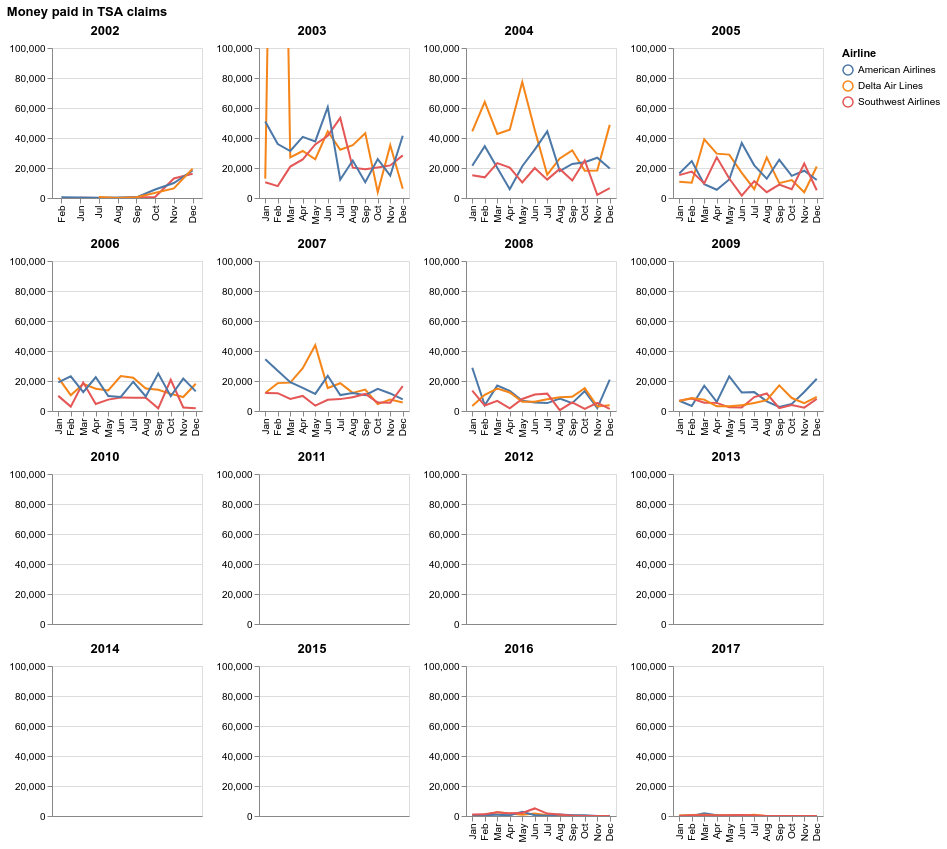

In [35]:
compound_chart = facet_wrap(charts, charts_per_row=4)
compound_chart.properties(title='Money paid in TSA claims')

In [41]:
file_path = os.path.abspath(os.path.join(PLOTS_PATH, 'compound_chart.html'))
compound_chart.save(file_path)

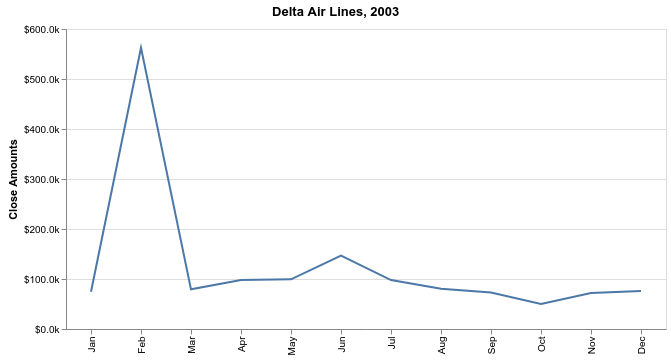

In [36]:
airline = 'Delta Air Lines'
year = '2003'

line_chart = alt.Chart(df).mark_line()\
.encode(
    x=alt.X('month_human', sort=months, axis=alt.Axis(title='')),
    y=alt.Y('sum(total_paid):Q', axis=alt.Axis(title='Close Amounts', format='$.1s')),
    order='month_number'
)\
.transform_filter(datum.year == year)\
.properties(title=f"{airline}, {year}", width=600)
line_chart

In [47]:
file_path = os.path.abspath(os.path.join(PLOTS_PATH, 'delta2003.html'))
line_chart.save(file_path)

Let's see an aggregate for each airline, to see if there is some sort of airline-specific seasonalities.

In [43]:
line_base = alt.Chart(df).mark_line().encode(
    x=alt.X('month_number', axis=alt.Axis(title='')),
    y=alt.Y('mean(total_paid):Q', axis=alt.Axis(title='', format='$.1s')),
    color=alt.Color('airline', title='Airline'),
)

ci_base = alt.Chart(df).mark_area(opacity=0.3).encode(
    x=alt.X('month_number', axis=alt.Axis(title='')),
    y=alt.Y('ci0(total_paid):Q'),
    y2='ci1(total_paid):Q',
    color=alt.Color('airline', title='Airline'),
)

In [44]:
def make_ci_line_chart(line_chart, ci_chart, airline, options):
    li = line_chart\
      .transform_filter(datum.airline == airline)\
      .properties(width=options['width'], height=options['height'], title=airline)
    
    ci = ci_chart\
      .transform_filter(datum.airline == airline)\
      .properties(width=options['width'], height=options['height'], title=airline)
    chart = ci + li
    return chart

In [45]:
top_three_airlines = ['American Airlines', 'Delta Air Lines', 'Southwest Airlines']
options = {'width': 200, 'height': 150}
charts = [make_ci_line_chart(line_base, ci_base, airline, options) for airline in top_three_airlines]

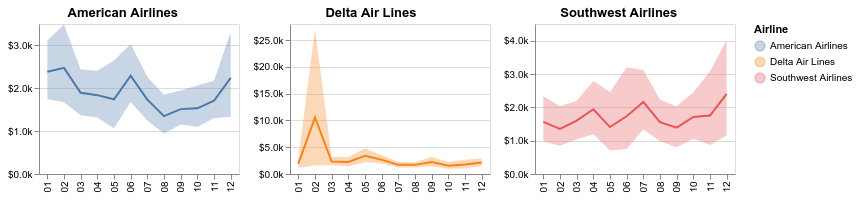

In [46]:
compound_chart = facet_wrap(charts, charts_per_row=3)
compound_chart

In [48]:
file_path = os.path.abspath(os.path.join(PLOTS_PATH, 'seasonality_trends.html'))
compound_chart.save(file_path)

## Histograms

Many records contain a close amount of `0.0`. They are the huge majority, but since we are interested in money actually paid, we filter them out.

In [52]:
sql = '''
SELECT
  date(c.date_received) AS date,
  trim(c.airline_name) AS airline,
  c.close_amount AS close_amount
FROM claims AS c
WHERE
  close_amount > 0 AND
  airline IN ("American Airlines", "Southwest Airlines", "Delta Air Lines")
'''

In [53]:
df = pd.read_sql(sql, con=engine)
df.shape

(32922, 3)

A few outliers would cause the distribution to be very right-skewed, so the histogram would not be very useful. We pick only up to 95th percentile to avoid this. Remember that we also removed zeros.

In [54]:
ca = df['close_amount']
df95 = df[ca <= ca.quantile(.95)]
df95.shape

(31275, 3)

In [55]:
hist_base = alt.Chart(df95).mark_bar()\
.encode(
    x=alt.X('close_amount', bin=alt.BinParams(step=10), axis=alt.Axis(title='Close Amount (binned)')),
    y='count():Q',
    color=alt.Color('airline', title='Airline'),
)

In [56]:
def make_hist(histogram_base_chart, airline, options):
    chart = histogram_base_chart\
      .transform_filter(datum.airline == airline)\
      .properties(width=options['width'], height=options['height'], title=airline)
    return chart

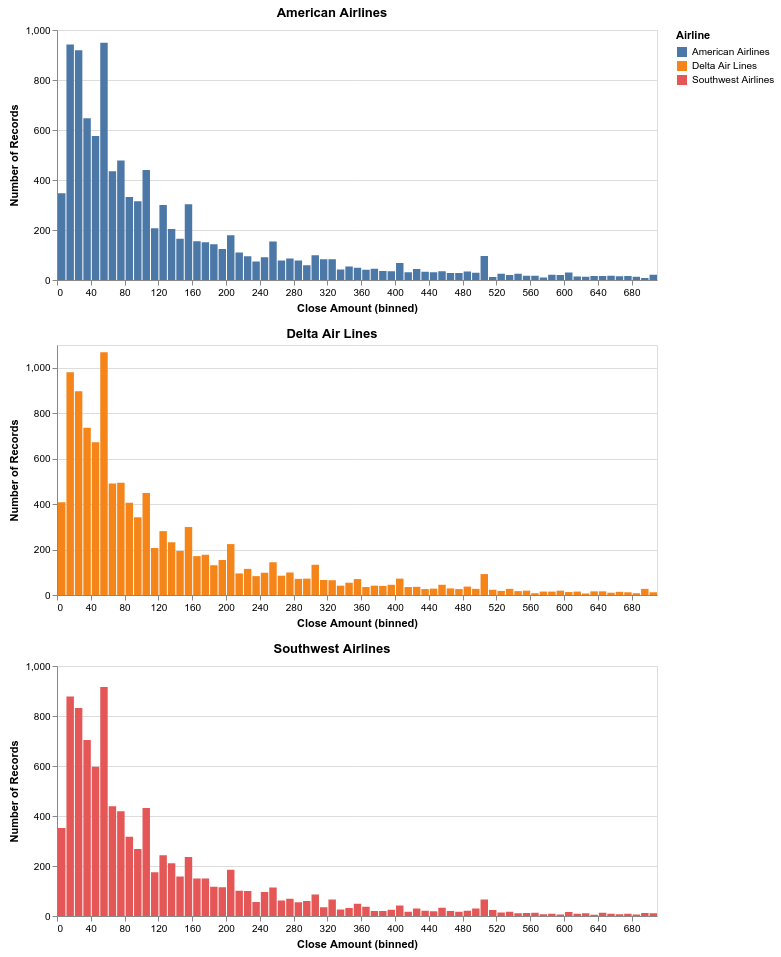

In [57]:
options = {'width': 600, 'height': 250}
charts = [make_hist(hist_base, airline, options) for airline in top_three_airlines]
compound_chart = facet_wrap(charts, charts_per_row=1)
compound_chart

In [58]:
file_path = os.path.abspath(os.path.join(PLOTS_PATH, 'histograms.html'))
compound_chart.save(file_path)

## Claim types and TSA dispositions

Some records apparently were not parsed correctly form the Excel/PDF files. For instance, `Passenger Property L oss` instead of `Passenger Property Loss`.

In [59]:
sql = '''
SELECT
  c.disposition,
  c.claim_type,
  COUNT(*) as num_claims
FROM claims AS c
GROUP BY c.claim_type, disposition
ORDER BY num_claims DESC
'''

In [60]:
df = pd.read_sql(sql, con=engine)
print(df.shape)
print(df.claim_type.unique())

(86, 3)
['Passenger Property Loss' 'Property Damage' None 'Personal Injury'
 'Motor Vehicle' 'Employee Loss (MPCECA)' 'Passenger Theft' 'Complaint'
 'Missed Flight' 'Compliment' 'Wrongful Death'
 'Pass enger Prop ert y Loss' 'Property Loss' 'Bus Terminal'
 'Not Provided' 'Pass enger Pro perty Los s' 'Passenge r Property  Lo ss'
 'Passenger Proper ty  Loss' 'Passenger Property  L oss'
 'Passenger Property L oss' 'Passenger Property Los s'
 'Passenger Property Loss/Personal Injur' 'Perso nal Injur y'
 'Property Damage/Personal Injury']


Luckily there are only a few incorrect records in the database, so we could simply discard them with a simple `HAVING` clause.

In [61]:
sql = '''
SELECT
  c.disposition,
  c.claim_type,
  COUNT(*) as num_claims
FROM claims AS c
GROUP BY c.claim_type, disposition
HAVING num_claims > 100
ORDER BY num_claims DESC
'''

In [62]:
df = pd.read_sql(sql, con=engine)
print(df.shape)
df

(28, 3)


disposition               claim_type  num_claims
0              Deny  Passenger Property Loss       76177
1              Deny          Property Damage       38501
2   Approve in Full  Passenger Property Loss       28512
3   Approve in Full          Property Damage       26826
4              None  Passenger Property Loss       20586
5            Settle  Passenger Property Loss       19825
6            Settle          Property Damage       18008
7              None          Property Damage       10933
8              None                     None        3332
9            Settle                     None        2602
10             Deny                     None        2541
11  Approve in Full                     None        2085
12        In Review          Property Damage        1143
13        In Review  Passenger Property Loss        1142
14             Deny          Personal Injury         840
15             None          Personal Injury         764
16    *Insufficient  Passenger Property Loss         216
17  Approve in Full            Motor Vehicle         199
18           Settle          Personal Injury         188
19  Approve in Full   Employee Loss (MPCECA)         186
20             Deny          Passenger Theft         183
21             Deny   Employee Loss (MPCECA)         169
22             None            Motor Vehicle         161
23  Approve in Full          Passenger Theft         142
24           Settle          Passenger Theft         117
25    *Insufficient          Property Damage         116
26  Approve in Full          Personal Injury         109
27           Settle   Employee Loss (MPCECA)         101

In [63]:
sql = '''
SELECT
  c.disposition,
  c.claim_type,
  COUNT(*) as num_claims
FROM claims AS c
GROUP BY c.claim_type, disposition
HAVING
  c.claim_type in ("Passenger Property Loss", "Property Damage") AND
  num_claims > 35
ORDER BY num_claims DESC
'''

In [64]:
df = pd.read_sql(sql, con=engine)
print(df.shape)
df

(14, 3)


disposition               claim_type  num_claims
0              Deny  Passenger Property Loss       76177
1              Deny          Property Damage       38501
2   Approve in Full  Passenger Property Loss       28512
3   Approve in Full          Property Damage       26826
4              None  Passenger Property Loss       20586
5            Settle  Passenger Property Loss       19825
6            Settle          Property Damage       18008
7              None          Property Damage       10933
8         In Review          Property Damage        1143
9         In Review  Passenger Property Loss        1142
10    *Insufficient  Passenger Property Loss         216
11    *Insufficient          Property Damage         116
12  Closed:Canceled  Passenger Property Loss          59
13  Closed:Canceled          Property Damage          38

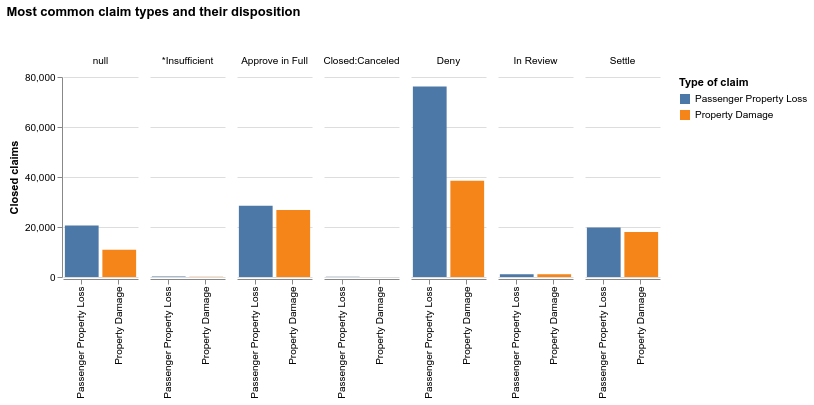

In [65]:
barchart = alt.Chart(df).mark_bar(stroke='transparent')\
.encode(
    x=alt.X('claim_type', axis=alt.Axis(title='')),
    y=alt.Y('num_claims', axis=alt.Axis(title='Closed claims', grid=True)),
    color=alt.Color('claim_type', title='Type of claim'),
    column=alt.Column('disposition', title=' ')  # use empty space to avoid having a figure title too close
)\
.configure_view(
    stroke='transparent'
)\
.configure_axis(
    domainWidth=1.0
)\
.properties(width=75, height=200, title='Most common claim types and their disposition')
barchart

In [67]:
file_path = os.path.abspath(os.path.join(PLOTS_PATH, 'barchart.html'))
barchart.save(file_path)